In [ ]:
#**********************************************#
# Visualization of the second stage network    #
#   results.                                   #
#**********************************************#

In [7]:
import full_pipeline as pipe
import pickle as pkl

# pipeline = pipe.Full_Pipeline.load_from_checkpoint('./full_log/full_save-100ep.ckpt').cuda().eval()
with open('./full_log/full_pipe.pkl', 'rb') as f:
    pipeline = pkl.load(f).cuda().eval()
train_set = pipe.Full_Dataset(pipe.valid_path)

In [8]:
import torch
import cosma_algebra as ca

# %matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

train_set.set_crop(64)
print(f"Len: {len(train_set)}")

ls = pipeline.loss.cuda()

Setting crop 64...
Len: 5845


In [9]:
full_struct_pred = False

In [10]:
def predict_draw(i):
    with torch.no_grad():
        pmtrx1, pmtrx2, amino1, amino2, cv1, cv2 = train_set.__getitem__(i, False)  # train_set[i]
        prot = train_set.load_item(i)
        coord1, coord2 = prot['coord']

        pmtrx1_tens = torch.tensor(np.array([pmtrx1]), device='cuda')
        pmtrx2_tens = torch.tensor(np.array([pmtrx2]), device='cuda')
        amino1_tens = torch.tensor(np.array([amino1]), device='cuda')
        amino2_tens = torch.tensor(np.array([amino2]), device='cuda')
        cv1_tens = torch.tensor(np.array([cv1]), device='cuda')
        cv2_tens = torch.tensor(np.array([cv2]), device='cuda')
        
        code256_1 = pipeline.model.encode_amino(amino1_tens)
        code256_2 = pipeline.model.encode_amino(amino2_tens)

        # cosma1_tens = pmtrx1_tens.mT @ pmtrx1_tens
        # cosma2_tens = pmtrx2_tens.mT @ pmtrx2_tens
        # code256_1 = pipeline.model.encode_cosma(cosma1_tens, amino1_tens)
        # code256_2 = pipeline.model.encode_cosma(cosma2_tens, amino2_tens)

        result = pipeline(amino1_tens, code256_1, amino2_tens, code256_2)
        true = pipeline.prepare_true_tensor(pmtrx1_tens, pmtrx2_tens, cv1_tens, cv2_tens)
        loss = ls(result, true).detach().cpu().numpy()

        # code256_1 = code256_1.detach().cpu().numpy()[0]
        # code256_2 = code256_2.detach().cpu().numpy()[0]

        cosma_pred, cv1_pred, cv2_pred = result.detach().cpu().numpy()[0]
        cosma_true, cv1_true, cv2_true = true.detach().cpu().numpy()[0]
        pmtrx1, pmtrx2 = pmtrx1[0], pmtrx2[0]

    print(loss)

    # Refining
    if full_struct_pred:
        # pmtrx1, pmtrx2 = ca.get_two_pmtrx_from_cosma_p1_p2_correct(cosma_pred)
        pmtrx1, pmtrx2 = ca.get_two_pmtrx_from_cosma_p1_p2(cosma_pred)
        # print(f"ERROR: {np.sqrt(np.mean((cosma_true - ca.get_cosma_from_pmtrx(pmtrx1, pmtrx2)) ** 2))}")
        coord1_, q, shift = ca.align_lmtrx_to_coord(pmtrx1 * 3.8, coord1, True)
        pmtrx1 = ca.get_pmtrx_from_coord(coord1_)
        pmtrx2 = q @ pmtrx2
        coord2_ = ca.get_coord_from_pmtrx(pmtrx2 * 3.8)
        s = np.eye(3)
    else:
        s = ca.get_s_from_cosma_p1_sp2(cosma_pred, pmtrx1, pmtrx2)
    cosma_refn = ca.cosma_from_pmtrx(pmtrx1, s @ pmtrx2)
    cosma_dev = np.sqrt(np.mean((cosma_pred - cosma_refn) ** 2))
    refine1 = ca.refine_cv_matrix(cv1_pred, pmtrx1, True)
    cv1_refn = ca.widen_upto(refine1['cv_md'], pmtrx2)
    refine2 = ca.refine_cv_matrix(cv2_pred.T, pmtrx2, True)
    cv2_refn = ca.widen_upto(refine2['cv_md'], pmtrx1).T

    with torch.no_grad():
        refined = torch.tensor(np.array([[cosma_refn, cv1_refn, cv2_refn]]), device='cuda', dtype=torch.float32)
        loss_refn = ls(refined, true).detach().cpu().numpy()

    print(f"devc: {cosma_dev}\ndev1: {refine1['dev']}\ndev2: {refine2['dev']}")
    print(loss_refn)

    plt.figure(dpi=225)
    plt.subplot(4, 3, 1).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cosma_true, cmap='gray')
    plt.subplot(4, 3, 2).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cv1_true, cmap='gray')
    plt.subplot(4, 3, 3).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cv2_true, cmap='gray')

    plt.subplot(4, 3, 4).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cosma_pred, cmap='gray')
    plt.subplot(4, 3, 5).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cv1_pred, cmap='gray')
    plt.subplot(4, 3, 6).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cv2_pred, cmap='gray')

    plt.subplot(4, 3, 7).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(np.abs(cosma_true - cosma_pred))
    plt.subplot(4, 3, 8).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(np.abs(cv1_true - cv1_pred))
    plt.subplot(4, 3, 9).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(np.abs(cv2_true - cv2_pred))

    plt.subplot(4, 3, 10).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cosma_refn, cmap='gray')
    plt.subplot(4, 3, 11).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cv1_refn, cmap='gray')
    plt.subplot(4, 3, 12).tick_params(axis='both', which='major', labelsize=4)
    plt.imshow(cv2_refn, cmap='gray')

    plt.show()

    ########################
    ###########LE#BUMP#####

    cv_3d = ca.normalize(refine1['cv_3d'] - s @ refine2['cv_3d'])
    if full_struct_pred:
        coord_pred = ca.bump_default(coord1_, coord2_, cv_3d)
        rmsd = ca.get_rmsd(coord2, coord_pred)
        print(f"RMSD: {rmsd}")
    else:
        coord_pred = ca.bump_default(coord1, s @ coord2, cv_3d)
        print(ca.compare_models(coord1, coord2, coord_pred, prot['homo']))

    fig = plt.figure(dpi=225)
    
    ax = fig.add_subplot(1, 2, 1, projection = '3d')
    prot1, prot2 = coord1, coord2
    ax.scatter(prot1[0, :], prot1[1, :], prot1[2, :], color = 'red', s = 5) #to make two plots...
    ax.plot(prot1[0, :], prot1[1, :], prot1[2, :], color = 'red', linewidth = 0.5)
    ax.scatter(prot2[0, :], prot2[1, :], prot2[2, :], color = 'blue', s = 5)
    ax.plot(prot2[0, :], prot2[1, :], prot2[2, :], color = 'blue', linewidth = 0.5)

    ax = fig.add_subplot(1, 2, 2, projection = '3d')
    if full_struct_pred:
        prot1, prot2 = coord1_, coord_pred
    else:
        prot1, prot2 = coord1, coord_pred
    ax.scatter(prot1[0, :], prot1[1, :], prot1[2, :], color = 'red', s = 5) #to make two plots...
    ax.plot(prot1[0, :], prot1[1, :], prot1[2, :], color = 'red', linewidth = 0.5)
    ax.scatter(prot2[0, :], prot2[1, :], prot2[2, :], color = 'blue', s = 5)
    ax.plot(prot2[0, :], prot2[1, :], prot2[2, :], color = 'blue', linewidth = 0.5)
    plt.show()


0.05580604
devc: 0.3027518093585968
dev1: 0.15721894800662994
dev2: 0.1494961678981781
0.0056832433


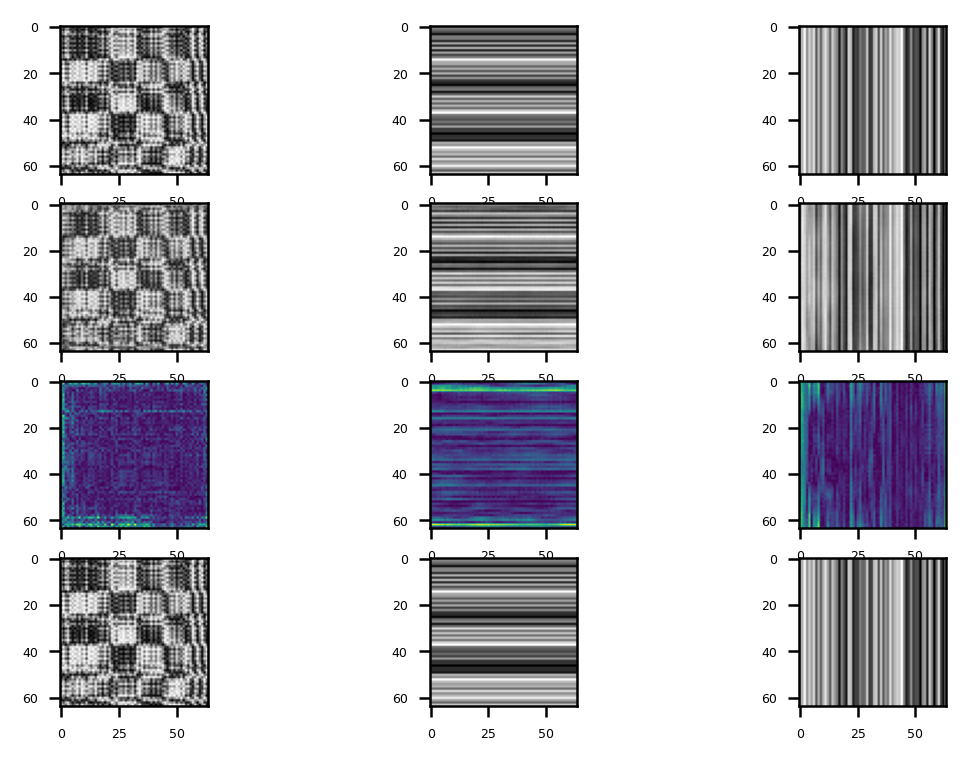

{'rmsd': 2.1037739521220047, 'cv_cos': 0.99770534, 'cv_angl': 3.8822171987590712, 's_norm': 0.17631111407776068}


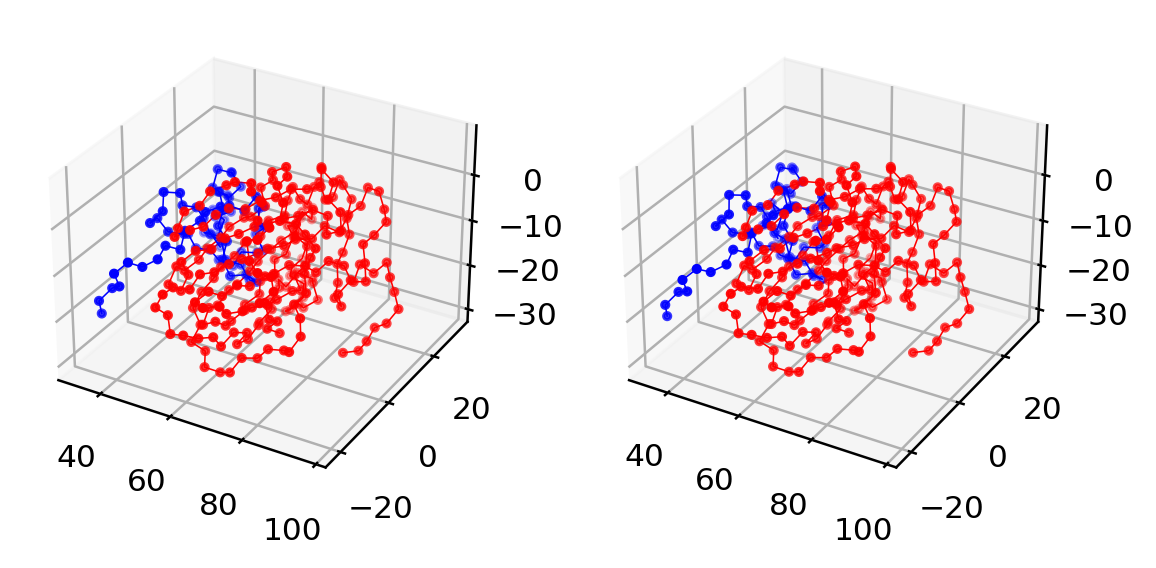

In [11]:
plt.close('all')
i = np.random.choice(len(train_set))
predict_draw(i)